In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Point, polygon
import contextily as ctx
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
from math import sqrt

In [2]:
#Importation des notre Dataframe
df_csv= pd.read_csv('p2-arbres-fr.csv', delimiter=';')

In [3]:
#Importation du fichier json
df=gpd.read_file('les-arbres.geojson')

In [4]:
df.columns

Index(['idbase', 'typeemplacement', 'domanialite', 'arrondissement',
       'complementadresse', 'numero', 'adresse', 'idemplacement',
       'libellefrancais', 'genre', 'espece', 'varieteoucultivar',
       'circonferenceencm', 'hauteurenm', 'stadedeveloppement', 'remarquable',
       'geometry'],
      dtype='object')

In [5]:
some_dict = {'idbase': 'id',
             'typeemplacement': 'type_emplacement',
             'complementadresse': 'complement_addresse',
            'adresse' :'lieu',
            'idemplacement':'id_emplacement',
            'libellefrancais':'libelle_francais',
             'varieteoucultivar' : 'variete',
             'circonferenceencm' : 'circonference_cm',
             'hauteurenm':'hauteur_m',
             'stadedeveloppement':'stade_developpement'
            }

In [6]:
df.rename(columns=some_dict, inplace=True)

In [7]:
df.head()

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geometry
0,258827,Arbre,Alignement,PARIS 15E ARRDT,110 bis,None,AVENUE DE SUFFREN,002204004,Platane,Platanus,x hispanica,None,75,12,Adulte,NON,POINT (2.30405 48.84907)
1,268490,Arbre,Alignement,PARIS 11E ARRDT,None,None,RUE OBERKAMPF,001701003,Tilleul,Tilia,tomentosa,None,85,10,Adulte,NON,POINT (2.37766 48.86578)
2,2012987,Arbre,Jardin,BOIS DE VINCENNES,None,None,INSEP / AVENUE DU TREMBLAY,00130102,Erable,Acer,pseudoplatanus,None,30,6,Jeune (arbre),NON,POINT (2.45264 48.82982)
3,225437,Arbre,Alignement,PARIS 10E ARRDT,f 33,None,BOULEVARD DE LA VILLETTE,000402012,Platane,Platanus,x hispanica,None,24,6,Jeune (arbre),NON,POINT (2.37446 48.87432)
4,231136,Arbre,Alignement,PARIS 14E ARRDT,None,None,RUE D ALESIA,002303001,Sophora,Styphnolobium,japonicum,None,125,10,Jeune (arbre)Adulte,NON,POINT (2.31880 48.83054)


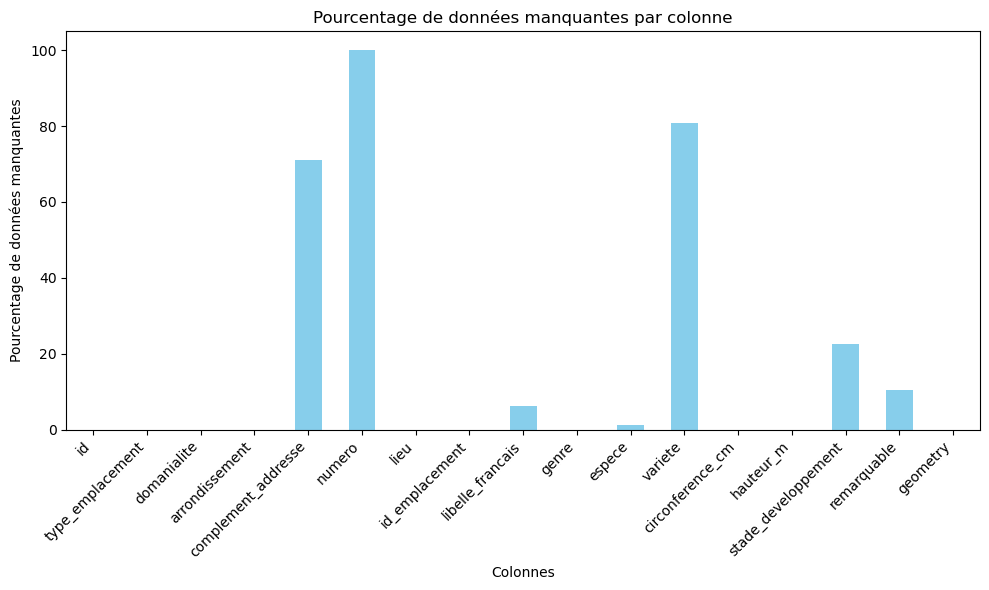

In [8]:
# Calculer le pourcentage de données manquantes par colonne
pourcentage_manquant_par_colonne = (df.isnull().sum() / len(df)) * 100

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
pourcentage_manquant_par_colonne.plot(kind='bar', color='skyblue')
plt.title('Pourcentage de données manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de données manquantes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Axes: >

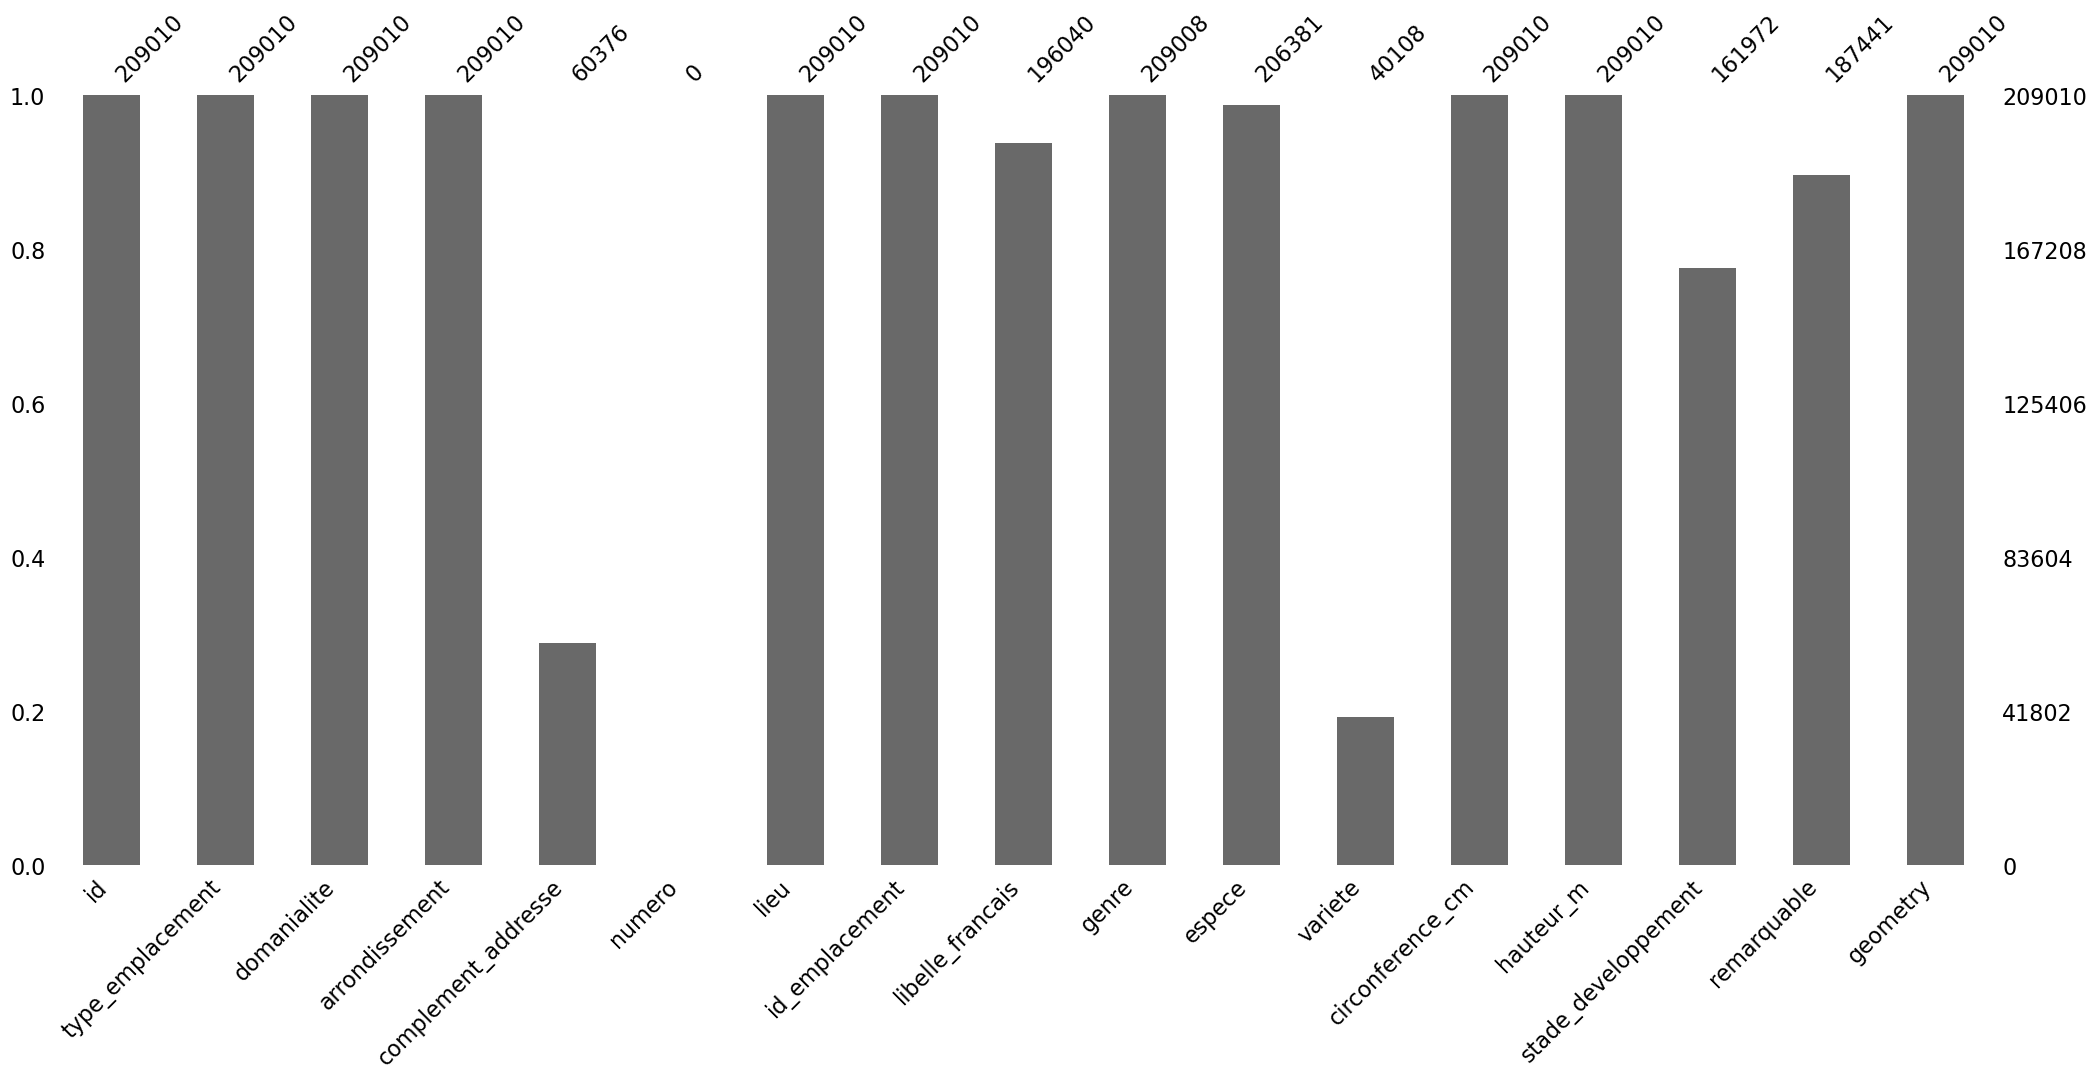

In [9]:
msno.bar(df)

In [10]:
#Affichage de Dataframe sans les colonnes complement_adresse, numero et type_emplacement
df_cleaned = df.drop(['complement_addresse', 'numero','type_emplacement'], axis=1)
df_cleaned.head()

,id,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geometry
0,258827,Alignement,PARIS 15E ARRDT,AVENUE DE SUFFREN,002204004,Platane,Platanus,x hispanica,None,75,12,Adulte,NON,POINT (2.30405 48.84907)
1,268490,Alignement,PARIS 11E ARRDT,RUE OBERKAMPF,001701003,Tilleul,Tilia,tomentosa,None,85,10,Adulte,NON,POINT (2.37766 48.86578)
2,2012987,Jardin,BOIS DE VINCENNES,INSEP / AVENUE DU TREMBLAY,00130102,Erable,Acer,pseudoplatanus,None,30,6,Jeune (arbre),NON,POINT (2.45264 48.82982)
3,225437,Alignement,PARIS 10E ARRDT,BOULEVARD DE LA VILLETTE,000402012,Platane,Platanus,x hispanica,None,24,6,Jeune (arbre),NON,POINT (2.37446 48.87432)
4,231136,Alignement,PARIS 14E ARRDT,RUE D ALESIA,002303001,Sophora,Styphnolobium,japonicum,None,125,10,Jeune (arbre)Adulte,NON,POINT (2.31880 48.83054)


In [11]:
#Identification des colonnes avec des valeurs manquantes
valeurs_manquantes_par_colonne = df_cleaned.isnull().sum()
print("Colonnes avec des valeurs manquantes :")
print(valeurs_manquantes_par_colonne)

Colonnes avec des valeurs manquantes :
id                          0
domanialite                 0
arrondissement              0
lieu                        0
id_emplacement              0
libelle_francais        12970
genre                       2
espece                   2629
variete                168902
circonference_cm            0
hauteur_m                   0
stade_developpement     47038
remarquable             21569
geometry                    0
dtype: int64


In [12]:
# Suppression des valeurs nulles des colonnes spécifiques
colonnes_a_nettoyer = ['variete', 'stade_developpement', 'remarquable','libelle_francais', 'espece']
df_cleaned = df_cleaned.dropna(subset=colonnes_a_nettoyer)

# Afficher les premières lignes du DataFrame nettoyé
print("\nDataFrame après suppression des valeurs manquantes :")
df_cleaned.head()


DataFrame après suppression des valeurs manquantes :


,id,domanialite,arrondissement,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geometry
7,133749,Jardin,PARIS 15E ARRDT,SQUARE CARLO SARRABEZOLLES / 1 RUE RENE RAVAUD,000203014,Peuplier,Populus,nigra,''Italica'',130,12,Adulte,NON,POINT (2.27130 48.83781)
13,293248,Alignement,PARIS 18E ARRDT,SQUARE CAULAINCOURT,000101007,Charme,Carpinus,betulus,''Fastigiata'',97,17,Jeune (arbre)Adulte,NON,POINT (2.33567 48.89001)
23,132360,Jardin,PARIS 5E ARRDT,JARDIN TINO ROSSI / 2B QUAI SAINT BERNARD,000304007,Peuplier,Populus,nigra,''Italica'',3,32,Mature,NON,POINT (2.35803 48.84927)
30,194917,PERIPHERIQUE,PARIS 17E ARRDT,TALUS N°17-04,091704032,Peuplier,Populus,nigra,''Italica'',132,15,Adulte,NON,POINT (2.28619 48.88501)
32,274962,Alignement,PARIS 2E ARRDT,BOULEVARD POISSONNIERE,000501011,Sophora,Styphnolobium,japonicum,''Regent'',38,7,Jeune (arbre),NON,POINT (2.34462 48.87115)


<Axes: >

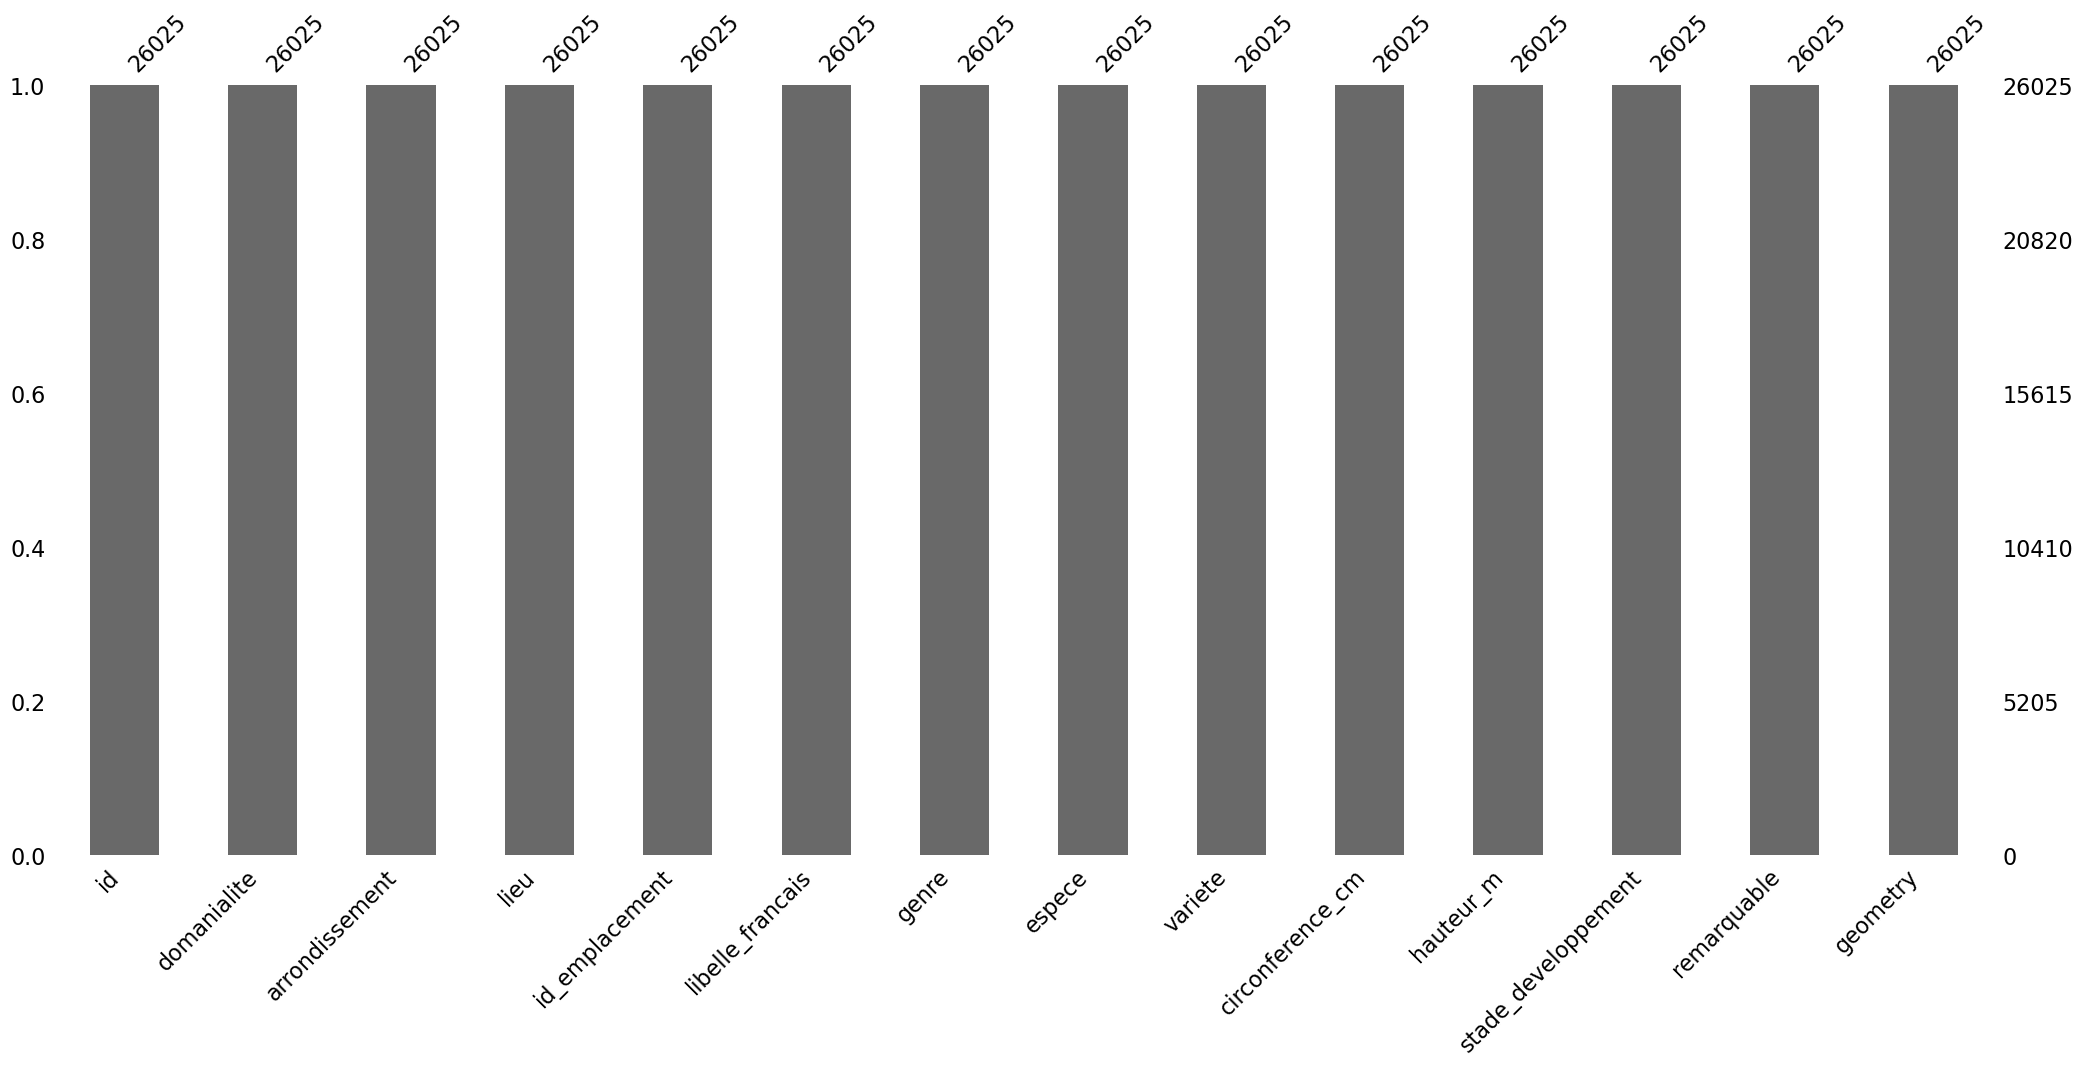

In [13]:
# Calculer le pourcentage de données manquantes par colonne
pourcentage_manquant_par_colonne = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

msno.bar(df_cleaned)

In [14]:
df.shape[0]

209010

In [15]:
#Calcul des statistiques descriptives pour les variables numériques
statistiques_descriptives = df[['circonference_cm', 'hauteur_m']].describe()

# Afficher les statistiques descriptives
statistiques_descriptives

,circonference_cm,hauteur_m
count,209010.000000,209010.000000
mean,80.920970,8.823434
std,63.082275,5.942785
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,2015.000000,170.000000


In [16]:
# Calculer les statistiques afficher la moyenne, min, max et médiane pour 'circonference_cm' et 'hauteur_m' 
stats = {
    'Moyenne': df_cleaned[['circonference_cm', 'hauteur_m']].mean(),
    'Minimum': df_cleaned[['circonference_cm', 'hauteur_m']].min(),
    'Maximum': df_cleaned[['circonference_cm', 'hauteur_m']].max(),
    'Médiane': df_cleaned[['circonference_cm', 'hauteur_m']].median()
}

# Créer un DataFrame à partir des statistiques calculées
stats_df = pd.DataFrame(stats)
stats_df

,Moyenne,Minimum,Maximum,Médiane
circonference_cm,69.619981,0,750,60.0
hauteur_m,7.971182,0,111,7.0


In [17]:
# Calculer les statistiques pour chaque genre par rapport à la circonference et la hauteur
stats_by_genre = df_cleaned.groupby('genre')[['circonference_cm', 'hauteur_m']].agg(['mean', 'min', 'max', 'median'])
stats_by_genre

circonference_cm                 hauteur_m               
                       mean min  max median      mean min max median
genre                                                               
Acacia            90.000000  90   90   90.0  7.000000   7   7    7.0
Acer              74.614802   3  300   70.0  8.703953   0  25    8.0
Aesculus          82.817598   3  448   75.0  9.164454   0  25    9.0
Alangium          20.000000  20   20   20.0  3.000000   3   3    3.0
Albizia           30.333333  10  126   20.0  4.000000   2   8    4.0
...                     ...  ..  ...    ...       ...  ..  ..    ...
Tilia             57.259951   5  160   55.0  7.533661   1  22    7.0
Toona             53.200000   5  235   36.0  6.980000   2  20    5.0
Ulmus             55.553191  20  240   31.0  5.276596   1  15    5.0
Zelkova           41.022222   2   70   44.0  6.133333   4   9    6.0
x Chitalpa        45.000000  20   70   45.0  4.500000   3   6    4.5

[70 rows x 8 columns]

In [18]:
# Calculer les statistiques pour chaque stade de développement
stats_by_stage = df_cleaned.groupby('stade_developpement')[['circonference_cm', 'hauteur_m']].agg(['mean', 'min', 'max', 'median'])

stats_by_stage

circonference_cm                  hauteur_m           \
                                mean min  max median       mean min  max   
stade_developpement                                                        
Adulte                    106.367843   0  750  100.0  10.999121   0   30   
Jeune (arbre)              32.110775   0  448   30.0   4.818005   0   40   
Jeune (arbre)Adulte        62.409451   0  180   60.0   7.635441   0  111   
Mature                    204.732218   3  480  205.0  16.424686   1   32   

                            
                    median  
stade_developpement         
Adulte                10.0  
Jeune (arbre)          5.0  
Jeune (arbre)Adulte    7.0  
Mature                18.0

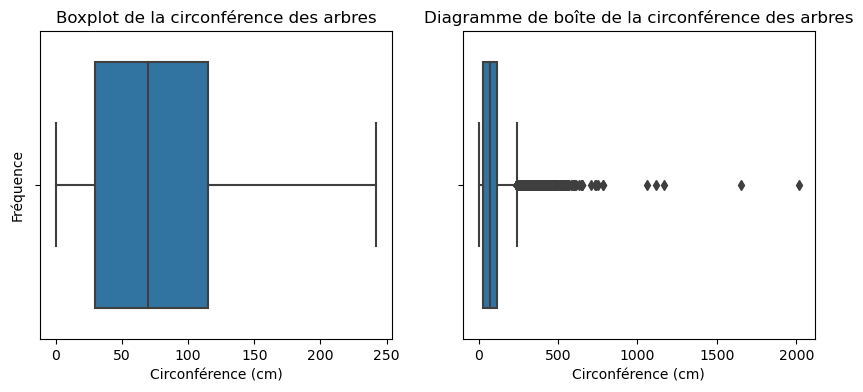

In [19]:
# Histogramme de la circonférence
fig,axes = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(data=df, x='circonference_cm',showfliers=False, ax=axes[0])
axes[0].set_title('Boxplot de la circonférence des arbres')
axes[0].set_xlabel('Circonférence (cm)')
axes[0].set_ylabel('Fréquence')

# Diagramme de boîte de la circonférence
sns.boxplot(data=df, x='circonference_cm',ax=axes[1])
axes[1].set_title('Diagramme de boîte de la circonférence des arbres')
axes[1].set_xlabel('Circonférence (cm)')

plt.show()

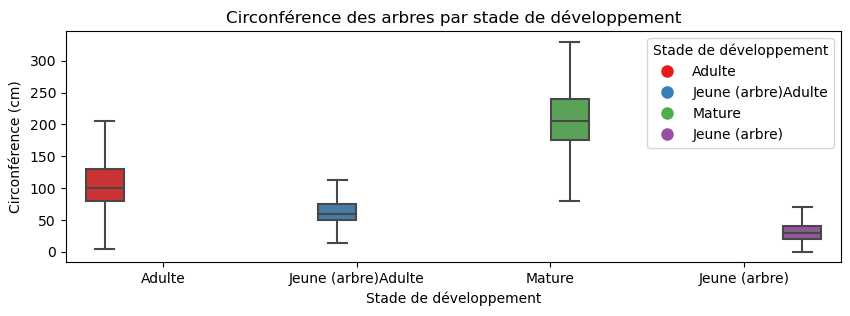

In [20]:
#Visualisation des données par stade de développement avec stripplot
colors = sns.color_palette('Set1')[:len(df_cleaned['stade_developpement'].unique())]
labels = df_cleaned['stade_developpement'].unique()

# Créer une légende personnalisée
legend_patches = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=8, linestyle='') for color, label in zip(colors, labels)]

plt.figure(figsize=(10, 3))
sns.boxplot(data=df_cleaned, x='stade_developpement', y='circonference_cm', hue='stade_developpement', showfliers=False, palette='Set1')
plt.title('Circonférence des arbres par stade de développement')
plt.xlabel('Stade de développement')
plt.ylabel('Circonférence (cm)')

plt.legend(handles=legend_patches, title='Stade de développement')
plt.show()

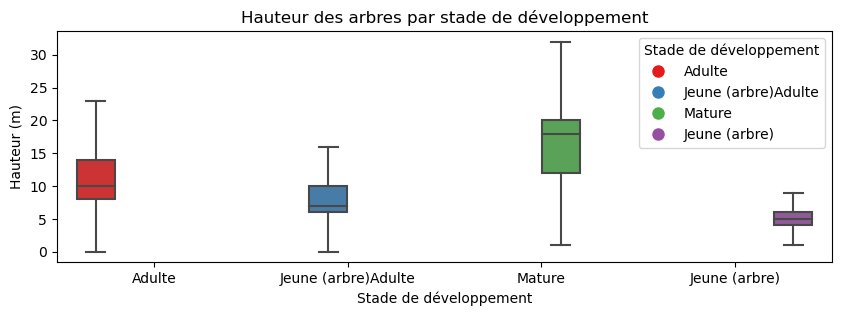

In [21]:
#Visualisation des données par stade de développement avec stripplot
colors = sns.color_palette('Set1')[:len(df_cleaned['stade_developpement'].unique())]
labels = df_cleaned['stade_developpement'].unique()

# Créer une légende personnalisée
legend_patches = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=8, linestyle='') for color, label in zip(colors, labels)]

plt.figure(figsize=(10, 3))
sns.boxplot(data=df_cleaned, x='stade_developpement', y='hauteur_m', hue='stade_developpement', showfliers=False, palette='Set1')
plt.title('Hauteur des arbres par stade de développement')
plt.xlabel('Stade de développement')
plt.ylabel('Hauteur (m)')

plt.legend(handles=legend_patches, title='Stade de développement')
plt.show()

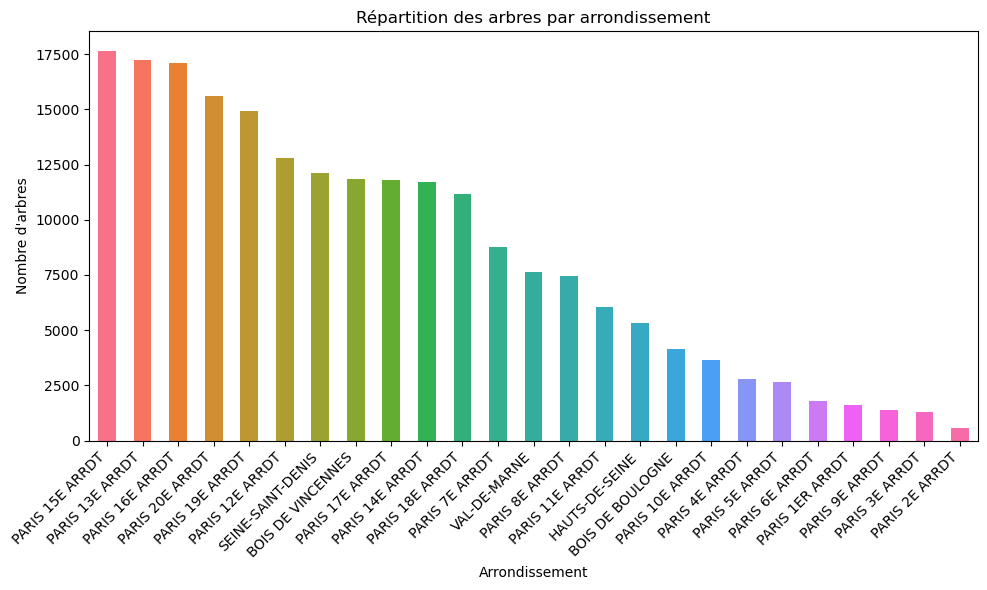

In [22]:
# Calculer le nombre d'arbres par arrondissement
arbres_par_arrondissement = df['arrondissement'].value_counts()

# Définir une palette de couleurs personnalisée pour chaque arrondissement
palette_couleurs = sns.color_palette('husl', n_colors=len(arbres_par_arrondissement))

# Créer le graphique à barres avec la palette de couleurs personnalisée
plt.figure(figsize=(10, 6))
arbres_par_arrondissement.plot(kind='bar', color=palette_couleurs)
plt.title('Répartition des arbres par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Nombre d\'arbres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
# Regrouper les données par arrondissement et genre d'arbre, puis compter le nombre d'arbres de chaque genre dans chaque arrondissement
genre_par_arrondissement = df.groupby(['arrondissement', 'genre'])['id'].count().reset_index()

# Trouver le genre d'arbre prédominant dans chaque arrondissement
genre_preponderant_par_arrondissement = genre_par_arrondissement.loc[genre_par_arrondissement.groupby('arrondissement')['id'].idxmax()]

# Afficher le résultat
genre_preponderant_par_arrondissement

,arrondissement,genre,id
1,BOIS DE BOULOGNE,Aesculus,1261
152,BOIS DE VINCENNES,Tilia,1953
165,HAUTS-DE-SEINE,Acer,1393
243,PARIS 10E ARRDT,Platanus,1131
316,PARIS 11E ARRDT,Platanus,1773
397,PARIS 12E ARRDT,Platanus,3705
499,PARIS 13E ARRDT,Platanus,2454
607,PARIS 14E ARRDT,Platanus,2583
738,PARIS 15E ARRDT,Tilia,2239
837,PARIS 16E ARRDT,Platanus,3910


In [24]:
#Regroupement de genre d'arbre par arrondissement et calculer les valeurs min, max, count et median / genre
genre_par_arrondissement = df.groupby(['arrondissement', 'genre'])['id'].agg(['min', 'max', 'count', 'median'])
genre_par_arrondissement 

min      max  count     median
arrondissement   genre                                                
BOIS DE BOULOGNE Acer                202646  2018007    497   234150.0
                 Aesculus            204588  2018008   1261  2000258.0
                 Araucaria          2002353  2002353      1  2002353.0
                 Carpinus            203119  2001472     64  2000155.5
                 Catalpa            2009236  2009236      1  2009236.0
...                                     ...      ...    ...        ...
VAL-DE-MARNE     Toona               152461   152582    104   152523.5
                 Ulmus               140054   171365     45   171338.0
                 Viburnum           2017106  2017106      1  2017106.0
                 Zelkova             140061   171360     11   159727.0
                 x Cupressocyparis   155372   155374      3   155373.0

[1995 rows x 4 columns]

In [25]:
# Obtenir l'index de la ligne avec le nombre le plus élevé d'arbres pour chaque arrondissement
indices_max = genre_par_arrondissement.groupby('arrondissement')['count'].idxmax()

# Sélectionner les lignes correspondantes dans le DataFrame genre_par_arrondissement
genre_le_plus_plante_par_arrondissement = genre_par_arrondissement.loc[indices_max]
genre_le_plus_plante_par_arrondissement

,,min,max,count,median
arrondissement,genre,,,,
BOIS DE BOULOGNE,Aesculus,204588,2018008,1261,2000258.0
BOIS DE VINCENNES,Tilia,201732,2030316,1953,2005643.0
HAUTS-DE-SEINE,Acer,140366,2024843,1393,143943.0
PARIS 10E ARRDT,Platanus,184209,2037707,1131,285415.0
PARIS 11E ARRDT,Platanus,115837,2038593,1773,238052.0
PARIS 12E ARRDT,Platanus,100322,2039708,3705,288314.0
PARIS 13E ARRDT,Platanus,109110,2038149,2454,225310.5
PARIS 14E ARRDT,Platanus,106995,2037637,2583,241221.0
PARIS 15E ARRDT,Tilia,102191,2040541,2239,250647.0


In [26]:
# Calculer le nombre total d'arbres par domanialité en agrégeant par domanialité et genre d'arbre
arbres_par_domanialite = df.groupby(['domanialite', 'genre'])['id'].count()

# Trier la colonne genre en ordre décroissant par domanialité
arbres_par_domanialite_trie = arbres_par_domanialite.groupby('domanialite', group_keys=False).nlargest()
arbres_par_domanialite_trie

domanialite   genre        
Alignement    Platanus         35720
              Aesculus         16198
              Tilia            12120
              Styphnolobium     8674
              Acer              6011
CIMETIERE     Acer              6476
              Aesculus          3947
              Tilia             3166
              Platanus          3121
              Fraxinus          2042
DAC           Tilia                9
              Acer                 7
              Platanus             7
              Prunus               7
              Carpinus             5
DASCO         Aesculus          1423
              Malus              829
              Platanus           815
              Pyrus              787
              Acer               755
DASES         Koelreuteria         5
              Prunus               4
              Cercis               3
              Platanus             3
              Ficus                2
DFPE          Prunus             249
          

In [27]:
df['domanialite'].unique()

array(['Alignement', 'Jardin', 'CIMETIERE', 'DASCO', 'DJS', 'DFPE',
       'PERIPHERIQUE', 'DAC', 'DASES'], dtype=object)

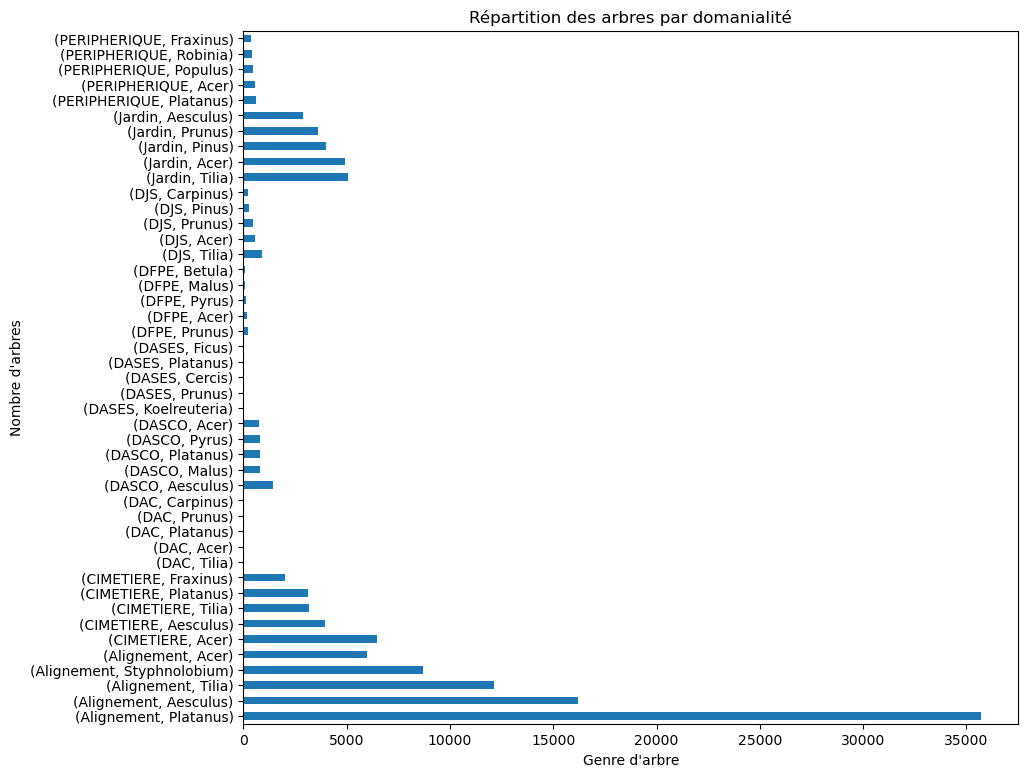

In [28]:
# Définir une palette de couleurs sous forme de dictionnaire
palette_couleurs_defaut = {
    'Alignement': 'red',
    'CIMETIERE': 'blue',
    'DAC': 'green',
    'DASCO': 'orange',
    'DASES': 'purple',
    'DFPE': 'yellow',
    'DJS': 'brown',
    'Jardin': 'pink',
    'PERIFERIQUE': 'black'
}
# Créer le graphique à barres horisontales
plt.figure(figsize=(10, 9))
arbres_par_domanialite_trie.plot(kind='barh')
# Ajouter des étiquettes et un titre
plt.xlabel('Genre d\'arbre')
plt.ylabel('Nombre d\'arbres')
plt.title('Répartition des arbres par domanialité')
plt.show()

In [29]:
# Grouper les données par région et par espèce, puis compter le nombre d'occurrences
arbres_par_region_espece = df.groupby(['arrondissement', 'genre']).size().reset_index(name='nombre_occurrences')

# Afficher le DataFrame avec le nombre d'occurrences de chaque espèce d'arbre dans chaque région
arbres_par_region_espece.sort_values('nombre_occurrences')


,arrondissement,genre,nombre_occurrences
1621,PARIS 7E ARRDT,Eucalyptus,1
1843,SEINE-SAINT-DENIS,Arbutus,1
520,PARIS 13E ARRDT,Torreya,1
1433,PARIS 4E ARRDT,Davidia,1
1431,PARIS 4E ARRDT,Cupressus,1
...,...,...,...
750,PARIS 16E ARRDT,Aesculus,3557
397,PARIS 12E ARRDT,Platanus,3705
1687,PARIS 8E ARRDT,Aesculus,3775
837,PARIS 16E ARRDT,Platanus,3910


In [30]:
df.duplicated().sum()

0

In [31]:
#Creation de la variable geometry pour paramettrages des plots
geometry= df['geometry']

In [32]:
#D
df_geo= gpd.GeoDataFrame(df, crs= 'epsg: 4326', geometry= geometry)

Text(0.5, 1.0, 'arrondissement')

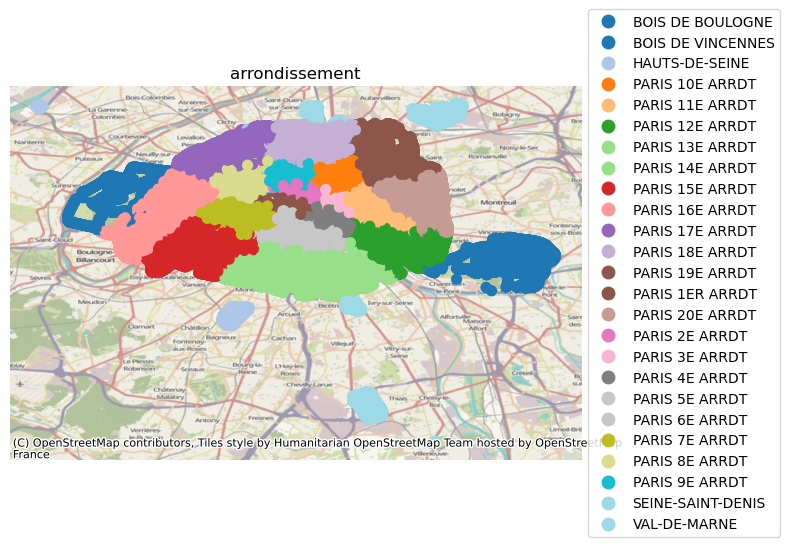

In [33]:
# Initialisation des plots
fig, ax = plt.subplots(figsize=(8,10))
# Plot our SF GeoDataFrame
#carte.plot(ax=ax, alpha = .1)
# Plot our Starbucks locations
df_geo.plot(ax=ax, column = df_geo['arrondissement'], cmap = 'tab20', marker = 'o', markersize=50,  legend = True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
# Add in a background using contextily
ctx.add_basemap(ax, crs=df_geo.crs.to_string())
# Turn off axis
ax.set_axis_off()
fig.tight_layout()
plt.title("arrondissement")

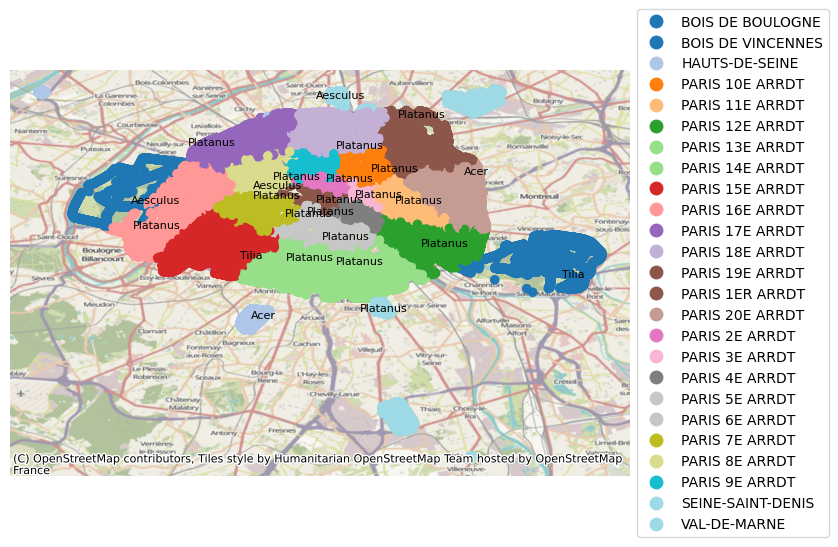

In [34]:
# On calcule le nombre d'arbres par arrondissement
nombre_arbres_par_arrondissement = df.groupby('arrondissement')['id'].count().reset_index()
nombre_arbres_par_arrondissement = nombre_arbres_par_arrondissement.rename(columns={'id': 'nombre_arbres'})

# On trouver l'arbre le plus planté dans chaque arrondissement
arbre_le_plus_plante_par_arrondissement = df.groupby(['arrondissement', 'genre'])['id'].count().reset_index()
idx = arbre_le_plus_plante_par_arrondissement.groupby(['arrondissement'])['id'].transform('max') == arbre_le_plus_plante_par_arrondissement['id']
arbre_le_plus_plante_par_arrondissement = arbre_le_plus_plante_par_arrondissement[idx]

# Création d'une carte et ajout des étiquettes pour les arbres les plus plantés
fig, ax = plt.subplots(figsize=(8,10))

# Plot du GeoDataFrame des arrondissements
df_geo.plot(ax=ax, column=df_geo['arrondissement'], cmap='tab20', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

# Ajout des étiquettes pour les arbres les plus plantés
for idx, row in arbre_le_plus_plante_par_arrondissement.iterrows():
    arrondissement = row['arrondissement']
    nom_espece = row['genre']
    coordonnees_arbre = df[(df['genre'] == nom_espece) & (df['arrondissement'] == arrondissement)].iloc[0].geometry
    ax.text(coordonnees_arbre.x, coordonnees_arbre.y, nom_espece, fontsize=8, ha='center')
# Ajout d'un fond de carte
ctx.add_basemap(ax, crs=df_geo.crs.to_string())

# Désactivation des axes
ax.set_axis_off()
# Affichage de la carte
plt.show()


In [35]:
# Debut de l'analyse pour la planification des intineraires - On groupe les arbres par arrondissement
arbres_par_arrondissement = df.groupby('arrondissement').size().reset_index(name='nombre_arbres')
arbres_par_arrondissement.head()

,arrondissement,nombre_arbres
0,BOIS DE BOULOGNE,4132
1,BOIS DE VINCENNES,11823
2,HAUTS-DE-SEINE,5337
3,PARIS 10E ARRDT,3654
4,PARIS 11E ARRDT,6067


In [36]:
# Remplacer les valeurs manquantes dans les colonnes 'stade_developpement' et 'espece'
df['stade_developpement'].fillna('Inconnu', inplace=True)
df['espece'].fillna('Inconnue', inplace=True)

In [37]:
# Compter le nombre de valeurs NaN dans la colonne 'stade_developpement' et 'espece'
nombre_nan = df['stade_developpement'].isna().sum()
nombre_nan = df['espece'].isna().sum()

# Afficher le nombre de valeurs NaN
print("Nombre de valeurs NaN dans la colonne 'stade_developpement' :", nombre_nan)
print("Nombre de valeurs NaN dans la colonne 'espece :", nombre_nan)

Nombre de valeurs NaN dans la colonne 'stade_developpement' : 0
Nombre de valeurs NaN dans la colonne 'espece : 0


In [38]:
# Nettoyer les données de la colonne 'geometry' et diviser en deux colonnes temporaires
df[['temp1', 'temp2']] = df['geometry'].astype(str).str.extract(r'(\d+\.\d+) (\d+\.\d+)')
# Affecter les valeurs des colonnes temporaires à 'latitude' et 'longitude'
df['latitude'] = df['temp1'].astype(float)
df['longitude'] = df['temp2'].astype(float)
# Supprimer les colonnes temporaires
df.drop(columns=['temp1', 'temp2'], inplace=True)

In [39]:
# Afficher les colonnes 'latitude' et 'longitude' dans le DataFrame
df[['latitude', 'longitude']]

,latitude,longitude
0,2.304051,48.849074
1,2.377658,48.865779
2,2.452637,48.829823
3,2.374460,48.874322
4,2.318802,48.830544
...,...,...
209005,2.335893,48.899390
209006,2.293221,48.857511
209007,2.387195,48.879867
209008,2.366640,48.864967


In [40]:
# Supprimer les doublons dans les colonnes "geometry", "longitude" et "latitude"
df.drop_duplicates(subset=['geometry', 'longitude', 'latitude'], keep='first', inplace=True)

# Réindexer le DataFrame après la suppression des doublons
df.reset_index(drop=True, inplace=True)

# Afficher le DataFrame après suppression des doublons
df

,id,type_emplacement,domanialite,arrondissement,complement_addresse,numero,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geometry,latitude,longitude
0,258827,Arbre,Alignement,PARIS 15E ARRDT,110 bis,None,AVENUE DE SUFFREN,002204004,Platane,Platanus,x hispanica,None,75,12,Adulte,NON,POINT (2.30405 48.84907),2.304051,48.849074
1,268490,Arbre,Alignement,PARIS 11E ARRDT,None,None,RUE OBERKAMPF,001701003,Tilleul,Tilia,tomentosa,None,85,10,Adulte,NON,POINT (2.37766 48.86578),2.377658,48.865779
2,2012987,Arbre,Jardin,BOIS DE VINCENNES,None,None,INSEP / AVENUE DU TREMBLAY,00130102,Erable,Acer,pseudoplatanus,None,30,6,Jeune (arbre),NON,POINT (2.45264 48.82982),2.452637,48.829823
3,225437,Arbre,Alignement,PARIS 10E ARRDT,f 33,None,BOULEVARD DE LA VILLETTE,000402012,Platane,Platanus,x hispanica,None,24,6,Jeune (arbre),NON,POINT (2.37446 48.87432),2.374460,48.874322
4,231136,Arbre,Alignement,PARIS 14E ARRDT,None,None,RUE D ALESIA,002303001,Sophora,Styphnolobium,japonicum,None,125,10,Jeune (arbre)Adulte,NON,POINT (2.31880 48.83054),2.318802,48.830544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208911,284337,Arbre,Alignement,PARIS 18E ARRDT,F16,None,AVENUE DE LA PORTE DE MONTMARTRE,000303001,Fevier,Gleditsia,triacanthos,''Skyline'',20,5,Inconnu,NON,POINT (2.33589 48.89939),2.335893,48.899390
208912,2032353,Arbre,Jardin,PARIS 7E ARRDT,Canton 01 / SETE,None,JARDIN DU CHAMP DE MARS ET PELOUSES DE L ECOLE...,P00106009,Fevier,Gleditsia,triacanthos f. Inermis,None,40,8,Jeune (arbre),NON,POINT (2.29322 48.85751),2.293221,48.857511
208913,2038008,Arbre,Jardin,PARIS 19E ARRDT,None,None,PARC DES BUTTES CHAUMONT / 7 RUE BOTZARIS,C01601022,Prunier à fleurs,Prunus,cerasifera,''Pissardii'',46,7,Inconnu,NON,POINT (2.38720 48.87987),2.387195,48.879867
208914,204040,Arbre,Alignement,PARIS 11E ARRDT,None,None,RUE AMELOT,002006002,Erable,Acer,platanoides,''Globosum'',75,10,Adulte,NON,POINT (2.36664 48.86497),2.366640,48.864967


In [41]:
# Compter le nombre d'arrondissements distincts dans la colonne "arrondissement"
nombre_arrondissements = df['arrondissement'].nunique()

print("Le nombre d'arrondissements distincts dans la colonne 'arrondissement' est :", nombre_arrondissements)

Le nombre d'arrondissements distincts dans la colonne 'arrondissement' est : 25


In [42]:
from itertools import permutations
import random

# Nombre de points à échantillonner
nombre_points_echantillon = 10

# Sélection aléatoire d'un sous-ensemble de points
indices_echantillon = random.sample(range(len(df)), nombre_points_echantillon)
points_echantillon = [(df.iloc[i]['latitude'], df.iloc[i]['longitude']) for i in indices_echantillon]

# Fonction pour calculer la distance entre deux points
def distance_entre_points(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5

# Fonction pour calculer la distance totale d'un parcours
def distance_totale(parcours, points):
    total_distance = 0
    for i in range(len(parcours) - 1):
        total_distance += distance_entre_points(points[parcours[i]], points[parcours[i+1]])
# Ajouter la distance pour revenir au point de départ
    total_distance += distance_entre_points(points[parcours[-1]], points[parcours[0]])
    return total_distance

# Générer toutes les permutations possibles des indices des arrondissements
tous_parcours = permutations(range(len(points_echantillon)))

# Initialiser la meilleure distance à une valeur infinie
meilleure_distance = float('inf')
meilleur_parcours = None

# Calculer la distance pour chaque parcours et trouver le meilleur
for parcours in tous_parcours:
    distance = distance_totale(parcours, points_echantillon)
    if distance < meilleure_distance:
        meilleure_distance = distance
        meilleur_parcours = parcours

# Afficher le meilleur parcours et sa distance totale
print("Meilleur parcours :", meilleur_parcours)
print("Distance totale de l'itinéraire optimal :", meilleure_distance)

Meilleur parcours : (0, 6, 3, 8, 5, 1, 7, 2, 4, 9)
Distance totale de l'itinéraire optimal : 0.4401097330497653


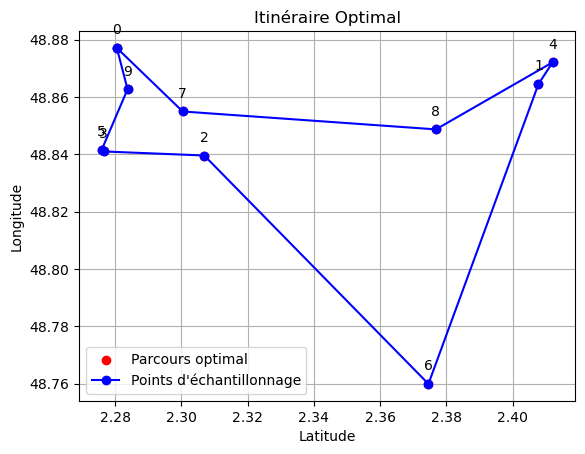

In [43]:
# Code échantillon pour verifier la fonctionnalité meilleur intineraire / Définir les points du parcours optimal
parcours_optimal = [points_echantillon[i] for i in meilleur_parcours]
# Ajouter le point de départ à la fin pour fermer la boucle
parcours_optimal.append(parcours_optimal[0])

# Extraire les coordonnées x et y des points
x = [point[0] for point in points_echantillon]
y = [point[1] for point in points_echantillon]

# Tracer les points
plt.scatter(x, y, color='red')

# Tracer le parcours optimal
x_optimal = [point[0] for point in parcours_optimal]
y_optimal = [point[1] for point in parcours_optimal]
plt.plot(x_optimal, y_optimal, linestyle='-', marker='o', color='blue')

# Ajouter des étiquettes aux points
for i, txt in enumerate(meilleur_parcours):
    plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Ajouter des titres et légendes
plt.title("Itinéraire Optimal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(True)
plt.legend(["Parcours optimal", "Points d'échantillonnage"], loc="best")

# Afficher le graphique
plt.show()

In [44]:
# Regrouper les données par arrondissement et prendre la première ligne de chaque groupe
arrondissements_unique_df = df.groupby('arrondissement').first().reset_index()
arrondissements_unique_df[['arrondissement']]

,arrondissement
0,BOIS DE BOULOGNE
1,BOIS DE VINCENNES
2,HAUTS-DE-SEINE
3,PARIS 10E ARRDT
4,PARIS 11E ARRDT
5,PARIS 12E ARRDT
6,PARIS 13E ARRDT
7,PARIS 14E ARRDT
8,PARIS 15E ARRDT
9,PARIS 16E ARRDT


In [45]:
# Afficher le DataFrame contenant chaque arrondissement unique avec sa latitude et sa longitude correspondantes
print(arrondissements_unique_df[['arrondissement', 'latitude', 'longitude']])

       arrondissement  latitude  longitude
0    BOIS DE BOULOGNE  2.257847  48.849003
1   BOIS DE VINCENNES  2.452637  48.829823
2      HAUTS-DE-SEINE  2.308715  48.806174
3     PARIS 10E ARRDT  2.374460  48.874322
4     PARIS 11E ARRDT  2.377658  48.865779
5     PARIS 12E ARRDT  2.375260  48.847127
6     PARIS 13E ARRDT  2.354263  48.820505
7     PARIS 14E ARRDT  2.318802  48.830544
8     PARIS 15E ARRDT  2.304051  48.849074
9     PARIS 16E ARRDT  2.254318  48.836589
10    PARIS 17E ARRDT  2.290607  48.887932
11    PARIS 18E ARRDT  2.335668  48.890011
12    PARIS 19E ARRDT  2.403077  48.877828
13    PARIS 1ER ARRDT  2.343558  48.862574
14    PARIS 20E ARRDT  2.394518  48.864534
15     PARIS 2E ARRDT  2.344622  48.871148
16     PARIS 3E ARRDT  2.366831  48.862143
17     PARIS 4E ARRDT  2.367145  48.853633
18     PARIS 5E ARRDT  2.358028  48.849273
19     PARIS 6E ARRDT  2.333036  48.853521
20     PARIS 7E ARRDT  2.297943  48.855368
21     PARIS 8E ARRDT  2.311372  48.869341
22     PARI

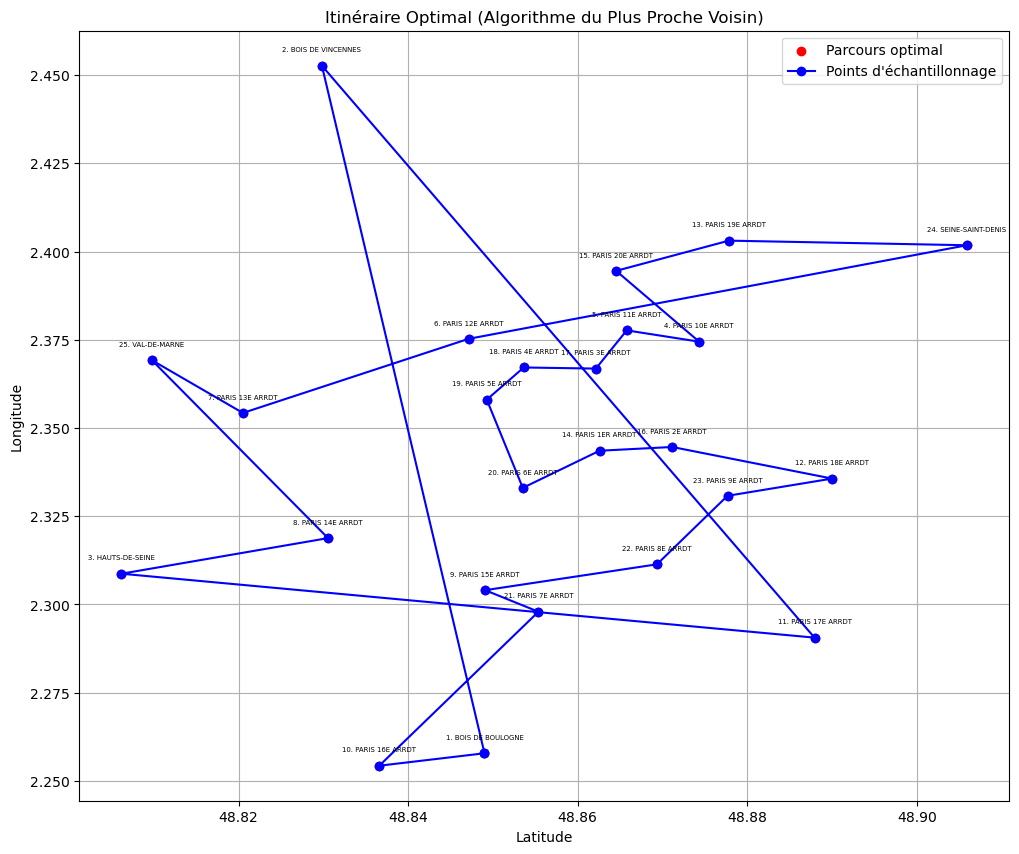

In [46]:
#Calcul du meilleur intineraire en passant par tous les arrondissements et revenir au point du départ
# Mon DataFrame contenant les arrondissements uniques avec leurs coordonnées
arrondissements_unique_df = pd.DataFrame({
    'arrondissement': ['BOIS DE BOULOGNE', 'BOIS DE VINCENNES', 'HAUTS-DE-SEINE', 'PARIS 10E ARRDT', 'PARIS 11E ARRDT',
                       'PARIS 12E ARRDT', 'PARIS 13E ARRDT', 'PARIS 14E ARRDT', 'PARIS 15E ARRDT', 'PARIS 16E ARRDT',
                       'PARIS 17E ARRDT', 'PARIS 18E ARRDT', 'PARIS 19E ARRDT', 'PARIS 1ER ARRDT', 'PARIS 20E ARRDT',
                       'PARIS 2E ARRDT', 'PARIS 3E ARRDT', 'PARIS 4E ARRDT', 'PARIS 5E ARRDT', 'PARIS 6E ARRDT',
                       'PARIS 7E ARRDT', 'PARIS 8E ARRDT', 'PARIS 9E ARRDT', 'SEINE-SAINT-DENIS', 'VAL-DE-MARNE'],
    'latitude': [48.849003, 48.829823, 48.806174, 48.874322, 48.865779, 48.847127, 48.820505, 48.830544, 48.849074,
                 48.836589, 48.887932, 48.890011, 48.877828, 48.862574, 48.864534, 48.871148, 48.862143, 48.853633,
                 48.849273, 48.853521, 48.855368, 48.869341, 48.877669, 48.905907, 48.809763],
    'longitude': [2.257847, 2.452637, 2.308715, 2.374460, 2.377658, 2.375260, 2.354263, 2.318802, 2.304051, 2.254318,
                  2.290607, 2.335668, 2.403077, 2.343558, 2.394518, 2.344622, 2.366831, 2.367145, 2.358028, 2.333036,
                  2.297943, 2.311372, 2.330786, 2.401775, 2.369215]
})

# Fonction pour calculer la distance entre deux points
def distance_entre_points(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5

# Fonction pour trouver le point le plus proche non visité
def trouver_plus_proche_non_visite(point, points, visites):
    min_distance = float('inf')
    plus_proche = None
    for i, p in enumerate(points):
        if i not in visites:
            distance = distance_entre_points(point, p)
            if distance < min_distance:
                min_distance = distance
                plus_proche = i
    return plus_proche

# Fonction pour calculer le parcours optimal en utilisant l'algorithme du plus proche voisin
def plus_proche_voisin(points):
    n = len(points)
    visites = set()
    parcours = []
    point_initial = points[0]
    visites.add(0)
    parcours.append(0)
    while len(visites) < n:
        dernier_point = points[parcours[-1]]
        prochain_point_index = trouver_plus_proche_non_visite(dernier_point, points, visites)
        visites.add(prochain_point_index)
        parcours.append(prochain_point_index)
    return parcours

# Convertir les arrondissements en points de coordonnées
points_echantillon = arrondissements_unique_df[['latitude', 'longitude', 'arrondissement']].values.tolist()

# Calculer le parcours optimal
parcours_optimal_indices = plus_proche_voisin(points_echantillon)

# Afficher le parcours optimal
parcours_optimal = [points_echantillon[i] for i in parcours_optimal_indices]
parcours_optimal.append(parcours_optimal[0])  # Ajouter le point de départ à la fin pour fermer la boucle

# Extraire les coordonnées x et y des points
x = [point[0] for point in points_echantillon]
y = [point[1] for point in points_echantillon]
noms_arrondissements = [point[2] for point in points_echantillon]

plt.figure(figsize=(12, 10))
# Tracer les points
plt.scatter(x, y, color='red')

# Tracer le parcours optimal
x_optimal = [point[0] for point in parcours_optimal]
y_optimal = [point[1] for point in parcours_optimal]
plt.plot(x_optimal, y_optimal, linestyle='-', marker='o', color='blue')

# Ajouter les noms des arrondissements aux points
for i, (nom, coord_x, coord_y) in enumerate(zip(noms_arrondissements, x, y)):
    plt.annotate(f"{i + 1}. {nom}", (coord_x, coord_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=5)

# Ajouter des titres et légendes
plt.title("Itinéraire Optimal (Algorithme du Plus Proche Voisin)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid(True)
plt.legend(["Parcours optimal", "Points d'échantillonnage"], loc="best")

# Afficher le graphique
plt.show()

In [95]:
# Calcule de la durée à prevoir pour l'entretien des arbres selon leur circonference : TEST
def duree_entretien(circonference_cm):
    if circonference_cm < 200:
        return "Faible entretien 5 min / mois)"
    elif 200 <= circonference_cm < 350:
        return "Entretien modéré (10 min / mois)"
    elif 350 <= circonference_cm < 600:
        return "Entretien moyen (15 min / mois)"
    else:
        return "Entretien élevé (20 min / mois ou plus)"

# Exemple d'utilisation
circonference_arbre = 500  # circonférence de l'arbre en centimètres
duree = duree_entretien(circonference_arbre)
print("La durée d'entretien prévue pour un arbre avec une circonférence de {} cm est : {}".format(circonference_arbre, duree))

La durée d'entretien prévue pour un arbre avec une circonférence de 500 cm est : Entretien moyen (15 min / mois)


In [48]:
circonference_unique = df['circonference_cm'].unique()
circonference_unique

array([  75,   85,   30,   24,  125,   45,  110,  130,  255,    0,  120,
        160,   97,  190,   20,   10,   70,  100,    3,  210,   65,  220,
         14,  132,   55,   38,  140,   67,   60,   63,   35,  145,   80,
         87,   25,   52,   95,   18,   96,  115,  150,  177,  185,   51,
         78,   90,  105,  157,   50,  235,   22,   73,   86,  183,  216,
        215,  225,   40,  121,   53,   48,  170,  182,   98,  205,   15,
         68,  155,   41,   93,  180,  232,   28,  195,  315,   36,   42,
        212,  166,  165,  230,   92,   49,   61,  200,  370,  135,  277,
         66,    5,   58,  162,   84,  250,  175,  142,  114,   44,  138,
        305,   31,    8,   91,  111,  152,  219,  131,  410,   54,  153,
        192,  218,  113,  274,   77,   16,   62,  300,   81,  129,  146,
        101,   94,  104,  124,   88,  128,  435,   82,   23,   43,  151,
        214,   32,  167,  276,  127,   46,  156,  187,  272,   34,  103,
         79,  168,  143,   64,  147,  126,  287,  1

In [98]:
# Calcule de la durée TOTALE à prevoir pour l'entretien des arbres selon leur circonference sur les données de mon DataFrame
def duree_entretien_circonference(circonference_cm):
    if circonference_cm < 100:
        return 1  #Temps d'entretien pour la catégorie "Faible entretien"(heure)
    elif 100 <= circonference_cm < 600:
        return 2  # Temps d'entretien pour la catégorie "Entretien modéré"(heure)
    elif 600 <= circonference_cm < 1000:
        return 3  # Temps d'entretien pour la catégorie "Entretien moyen"(heure)
    else:
        return 4  # Temps d'entretien pour la catégorie "Entretien élevé"(heure)

# Calculer la somme du temps d'entretien passé en fonction de la circonférence des arbres
duree_totale_entretien_circonference = df['circonference_cm'].apply(duree_entretien_circonference).sum()

# Afficher la durée totale d'entretien pour tous les arbres en fonction de la circonférence
print("La durée totale d'entretien prévue pour tous les arbres en fonction de la circonférence est de :", duree_totale_entretien_circonference, "heures")

La durée totale d'entretien prévue pour tous les arbres en fonction de la circonférence est de : 279595 heures


In [99]:
# Calculer la durée d'entretien prévue pour CHAQUE arbre en fonction de la circonférence
df['duree_entretien_circonference'] = df['circonference_cm'].apply(duree_entretien)

# Regrouper par arrondissement et calculer la somme des durées d'entretien prévues
durees_par_arrondissement = df.groupby('arrondissement')['duree_entretien_circonference'].sum().reset_index()

# Afficher les durées d'entretien prévues par arrondissement
durees_par_arrondissement

,arrondissement,duree_entretien_circonference
0,BOIS DE BOULOGNE,Faible entretien 5 min / mois)Faible entretien...
1,BOIS DE VINCENNES,Faible entretien 5 min / mois)Faible entretien...
2,HAUTS-DE-SEINE,Faible entretien 5 min / mois)Faible entretien...
3,PARIS 10E ARRDT,Faible entretien 5 min / mois)Faible entretien...
4,PARIS 11E ARRDT,Faible entretien 5 min / mois)Faible entretien...
5,PARIS 12E ARRDT,Faible entretien 5 min / mois)Faible entretien...
6,PARIS 13E ARRDT,Faible entretien 5 min / mois)Faible entretien...
7,PARIS 14E ARRDT,Faible entretien 5 min / mois)Faible entretien...
8,PARIS 15E ARRDT,Faible entretien 5 min / mois)Faible entretien...
9,PARIS 16E ARRDT,Entretien modéré (10 min / mois)Faible entreti...


In [100]:
# Calcule de la durée à prévoir pour l'entretien des arbres selon leur hauteur sur les données de mon DataFrame
def duree_entretien_hauteur(hauteur_m):
    if hauteur_m < 1:
        return 1  # Temps d'entretien pour la catégorie "Faible entretien"
    elif 1 <= hauteur_m < 30:
        return 2  # Temps d'entretien pour la catégorie "Entretien modéré"
    elif 30 <= hauteur_m < 140:
        return 3  # Temps d'entretien pour la catégorie "Entretien moyen"
    else:
        return 4  # Temps d'entretien pour la catégorie "Entretien élevé"

# Calculer la somme du temps d'entretien passé en fonction de la hauteur des arbres
duree_totale_entretien_hauteur = df['hauteur_m'].apply(duree_entretien_hauteur).sum()

# Afficher la durée totale d'entretien pour tous les arbres en fonction de la hauteur
print("La durée totale d'entretien prévue pour tous les arbres en fonction de la hauteur est de :", duree_totale_entretien_hauteur, "heures")

La durée totale d'entretien prévue pour tous les arbres en fonction de la hauteur est de : 393481 heures


In [101]:
# Calculer la durée d'entretien prévue pour chaque arbre en fonction de la hauteur
df['duree_entretien_hauteur'] = df['hauteur_m'].apply(duree_entretien)

# Regrouper par arrondissement et calculer la somme des durées d'entretien prévues
durees_par_arrondissement = df.groupby('arrondissement')['duree_entretien_hauteur'].sum().reset_index()

durees_par_arrondissement

,arrondissement,duree_entretien_hauteur
0,BOIS DE BOULOGNE,Faible entretien 5 min / mois)Faible entretien...
1,BOIS DE VINCENNES,Faible entretien 5 min / mois)Faible entretien...
2,HAUTS-DE-SEINE,Faible entretien 5 min / mois)Faible entretien...
3,PARIS 10E ARRDT,Faible entretien 5 min / mois)Faible entretien...
4,PARIS 11E ARRDT,Faible entretien 5 min / mois)Faible entretien...
5,PARIS 12E ARRDT,Faible entretien 5 min / mois)Faible entretien...
6,PARIS 13E ARRDT,Faible entretien 5 min / mois)Faible entretien...
7,PARIS 14E ARRDT,Faible entretien 5 min / mois)Faible entretien...
8,PARIS 15E ARRDT,Faible entretien 5 min / mois)Faible entretien...
9,PARIS 16E ARRDT,Faible entretien 5 min / mois)Faible entretien...


In [102]:
# Regrouper par arrondissement et calculer la somme des durées d'entretien prévues
durees_par_arrondissement = df.groupby('arrondissement')['duree_entretien_circonference'].sum().reset_index()

durees_par_arrondissement

,arrondissement,duree_entretien_circonference
0,BOIS DE BOULOGNE,Faible entretien 5 min / mois)Faible entretien...
1,BOIS DE VINCENNES,Faible entretien 5 min / mois)Faible entretien...
2,HAUTS-DE-SEINE,Faible entretien 5 min / mois)Faible entretien...
3,PARIS 10E ARRDT,Faible entretien 5 min / mois)Faible entretien...
4,PARIS 11E ARRDT,Faible entretien 5 min / mois)Faible entretien...
5,PARIS 12E ARRDT,Faible entretien 5 min / mois)Faible entretien...
6,PARIS 13E ARRDT,Faible entretien 5 min / mois)Faible entretien...
7,PARIS 14E ARRDT,Faible entretien 5 min / mois)Faible entretien...
8,PARIS 15E ARRDT,Faible entretien 5 min / mois)Faible entretien...
9,PARIS 16E ARRDT,Entretien modéré (10 min / mois)Faible entreti...


In [103]:
# Compter le nombre d'arbres par arrondissement
nombre_arbres_par_arrondissement = df['arrondissement'].value_counts().reset_index()
nombre_arbres_par_arrondissement.columns = ['arrondissement', 'nombre_arbres']
nombre_arbres_par_arrondissement

,arrondissement,nombre_arbres
0,PARIS 15E ARRDT,17649
1,PARIS 13E ARRDT,17184
2,PARIS 16E ARRDT,17105
3,PARIS 20E ARRDT,15622
4,PARIS 19E ARRDT,14902
5,PARIS 12E ARRDT,12817
6,SEINE-SAINT-DENIS,12116
7,BOIS DE VINCENNES,11820
8,PARIS 17E ARRDT,11804
9,PARIS 14E ARRDT,11724


In [104]:
# Calculer le temps d'entretien nécessaire par arbre en fonction de la circonférence
df['temps_entretien_par_arrondissement_cm'] = df['circonference_cm'].apply(duree_entretien_circonference)

# Calculer le temps d'entretien total par arrondissement en multipliant le nombre d'arbres par le temps d'entretien par arbre
temps_entretien_par_arrondissement = df.groupby('arrondissement')['temps_entretien_par_arrondissement_cm'].sum().reset_index()

# Afficher le DataFrame avec le temps d'entretien total par arrondissement
temps_entretien_par_arrondissement

,arrondissement,temps_entretien_par_arrondissement_cm
0,BOIS DE BOULOGNE,5562
1,BOIS DE VINCENNES,16246
2,HAUTS-DE-SEINE,5769
3,PARIS 10E ARRDT,4790
4,PARIS 11E ARRDT,7955
5,PARIS 12E ARRDT,16921
6,PARIS 13E ARRDT,21783
7,PARIS 14E ARRDT,16678
8,PARIS 15E ARRDT,22301
9,PARIS 16E ARRDT,23701


In [106]:
# Supposons que vous ayez une colonne 'temps_entretien_total' dans votre DataFrame contenant le nombre total d'heures d'entretien par arrondissement
nombre_jours_travailles = 220  # Nombre de jours travaillés dans l'année

# Calculer le temps d'entretien par jour par arrondissement
temps_entretien_par_arrondissement['temps_entretien_par_jour'] = temps_entretien_par_arrondissement['temps_entretien_par_arrondissement_cm'] / nombre_jours_travailles

# Afficher le DataFrame avec le temps d'entretien par jour par arrondissement
temps_entretien_par_arrondissement

,arrondissement,temps_entretien_par_arrondissement_cm,temps_entretien_par_jour
0,BOIS DE BOULOGNE,5562,25.281818
1,BOIS DE VINCENNES,16246,73.845455
2,HAUTS-DE-SEINE,5769,26.222727
3,PARIS 10E ARRDT,4790,21.772727
4,PARIS 11E ARRDT,7955,36.159091
5,PARIS 12E ARRDT,16921,76.913636
6,PARIS 13E ARRDT,21783,99.013636
7,PARIS 14E ARRDT,16678,75.809091
8,PARIS 15E ARRDT,22301,101.368182
9,PARIS 16E ARRDT,23701,107.731818


In [107]:
# Calculer le temps d'entretien nécessaire par arbre en fonction de l'hauteur
df['temps_entretien_par_arrondissement_m'] = df['hauteur_m'].apply(duree_entretien_hauteur)

# Calculer le temps d'entretien total par arrondissement en multipliant le nombre d'arbres par le temps d'entretien par arbre
temps_entretien_par_arrondissement = df.groupby('arrondissement')['temps_entretien_par_arrondissement_m'].sum().reset_index()

temps_entretien_par_arrondissement

,arrondissement,temps_entretien_par_arrondissement_m
0,BOIS DE BOULOGNE,8364
1,BOIS DE VINCENNES,21092
2,HAUTS-DE-SEINE,6908
3,PARIS 10E ARRDT,7310
4,PARIS 11E ARRDT,12067
5,PARIS 12E ARRDT,25292
6,PARIS 13E ARRDT,33725
7,PARIS 14E ARRDT,23285
8,PARIS 15E ARRDT,30500
9,PARIS 16E ARRDT,34119


In [108]:
# Supposons que vous ayez une colonne 'temps_entretien_total' dans votre DataFrame contenant le nombre total d'heures d'entretien par arrondissement
nombre_jours_travailles = 220  # Nombre de jours travaillés dans l'année

# Calculer le temps d'entretien par semaine par arrondissement
temps_entretien_par_arrondissement['temps_entretien_par_jour'] = temps_entretien_par_arrondissement['temps_entretien_par_arrondissement_m'] / nombre_jours_travailles

# Afficher le DataFrame avec le temps d'entretien par jour par arrondissement
temps_entretien_par_arrondissement

,arrondissement,temps_entretien_par_arrondissement_m,temps_entretien_par_jour
0,BOIS DE BOULOGNE,8364,38.018182
1,BOIS DE VINCENNES,21092,95.872727
2,HAUTS-DE-SEINE,6908,31.400000
3,PARIS 10E ARRDT,7310,33.227273
4,PARIS 11E ARRDT,12067,54.850000
5,PARIS 12E ARRDT,25292,114.963636
6,PARIS 13E ARRDT,33725,153.295455
7,PARIS 14E ARRDT,23285,105.840909
8,PARIS 15E ARRDT,30500,138.636364
9,PARIS 16E ARRDT,34119,155.086364
